## Download data

In [ ]:
import stock_data as stock

scrapy = stock.Scrapy()
price = scrapy.get_price(
    start = "2022-01-01",
    end = "2023-02-01",
    mode = "listed"
)
price

In [ ]:
import stock_data as stock

scrapy = stock.Scrapy()
chip = scrapy.get_chip_data(
    start  = "2022-01-01",
    end = "2023-02-01",
    mode = "listed"
)
chip

In [ ]:
price.to_csv("data/price.csv", index = False)
chip.to_csv("data/chip.csv", index = False)

# Processing

In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
price = pd.read_csv("data/price.csv", parse_dates = ["Date"])
chip = pd.read_csv("data/chip.csv", parse_dates = ["date"])

In [3]:
price["Date"] = price["Date"].dt.date
price["Date"] = pd.to_datetime(price["Date"])
price["Symbol"] = price["Symbol"].str[:-3].astype(int)
price = price[["Symbol", "Date", "Close", "Adj Close", "Volume"]]
price = price.sort_values(["Symbol", "Date"]).reset_index(drop = True)
price["Volume"] = (price["Volume"] * 0.001).round()
price

,Symbol,Date,Close,Adj Close,Volume
0,1101,2022-01-03,43.14,42.00,13592.0
1,1101,2022-01-04,43.00,41.87,12594.0
2,1101,2022-01-05,42.87,41.73,10689.0
3,1101,2022-01-06,43.28,42.13,13609.0
4,1101,2022-01-07,43.14,42.00,12027.0
...,...,...,...,...,...
249472,9958,2023-01-12,92.60,92.60,2725.0
249473,9958,2023-01-13,91.70,91.70,1662.0
249474,9958,2023-01-16,92.90,92.90,2116.0
249475,9958,2023-01-17,95.00,95.00,4329.0


In [4]:
chip = chip[["code", "date", "foreignNetBuySell"]]
chip

,code,date,foreignNetBuySell
0,1101,2022-01-03,4400
1,1101,2022-01-04,1793
2,1101,2022-01-05,-69
3,1101,2022-01-06,5621
4,1101,2022-01-07,2247
...,...,...,...
237143,6854,2023-01-12,-3
237144,6854,2023-01-13,-5
237145,6854,2023-01-17,-2
237146,6854,2023-01-30,2


In [5]:
df = pd.merge(price, chip, left_on = ["Symbol", "Date"], right_on = ["code", "date"], how = "left")
df = df.drop(["code", "date"], axis = 1)
df.columns = ['symbol', 'date', 'close', 'adj_close', 'volume', 'foreign']

In [6]:
df = df.fillna(0)
df["foreign"] = df["foreign"].astype(int)
df["volume"] = df["volume"].astype(int)

In [7]:
g = df.groupby("symbol")
group = g.size().index

df1 = pd.DataFrame()

for symbol in tqdm(group):
    df2 = g.get_group(symbol).copy()

    df2["foreign_last1"] = df2["foreign"].shift(1)
    df2["foreign_last2"] = df2["foreign"].shift(2)

    df2["foreign_return"] = df2["foreign"] / df2["foreign_last1"]
    df2["foreign_return_last1"] = df2["foreign_last1"] / df2["foreign_last2"]

    df2["return"] = (df2["adj_close"].pct_change(1) * 100).round(2)
    df2["return_3"] = (df2["adj_close"].pct_change(3) * 100).round(2)
    
    df2["return_next1"] = df2["return"].shift(-1)

    df1 = pd.concat([df1, df2.iloc[:-1]])

df1

100%|██████████| 968/968 [00:07<00:00, 133.84it/s]


,symbol,date,close,adj_close,volume,foreign,foreign_last1,foreign_last2,foreign_return,foreign_return_last1,return,return_3,return_next1
0,1101,2022-01-03,43.14,42.00,13592,4400,NaN,NaN,NaN,NaN,NaN,NaN,-0.31
1,1101,2022-01-04,43.00,41.87,12594,1793,4400.0,NaN,0.407500,NaN,-0.31,NaN,-0.33
2,1101,2022-01-05,42.87,41.73,10689,-69,1793.0,4400.0,-0.038483,0.407500,-0.33,NaN,0.96
3,1101,2022-01-06,43.28,42.13,13609,5621,-69.0,1793.0,-81.463768,-0.038483,0.96,0.31,-0.31
4,1101,2022-01-07,43.14,42.00,12027,2247,5621.0,-69.0,0.399751,-81.463768,-0.31,0.31,-0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249471,9958,2023-01-11,93.30,93.30,2958,54,0.0,1897.0,inf,0.000000,0.00,3.90,-0.75
249472,9958,2023-01-12,92.60,92.60,2725,584,54.0,0.0,10.814815,inf,-0.75,-0.75,-0.97
249473,9958,2023-01-13,91.70,91.70,1662,148,584.0,54.0,0.253425,10.814815,-0.97,-1.71,1.31
249474,9958,2023-01-16,92.90,92.90,2116,980,148.0,584.0,6.621622,0.253425,1.31,-0.43,2.26


In [8]:
import numpy as np
df1["foreign_return"] = df1["foreign_return"].replace(np.inf, 0)
df1["foreign_return_last1"] = df1["foreign_return_last1"].replace(np.inf, 0)

In [42]:
flag1 = (df1[["foreign", "foreign_last1", "foreign_last2"]] > 0).all(axis = 1)
flag2 = (df1["foreign_last2"] > 500)
flag3 = (df1[["foreign_return", "foreign_return_last1"]] > 2).all(axis = 1)
flag4 = (df1["foreign_return"] >= df1["foreign_return_last1"])
flag5 = (df1["return_3"] < 5) & (df1["return_3"] > 0) & (df1["return"] > 0)

In [43]:
df1["flag"] = (flag1 & flag2 & flag3 & flag4 & flag5)
df1

,symbol,date,close,adj_close,volume,foreign,foreign_last1,foreign_last2,foreign_return,foreign_return_last1,return,return_3,return_next1,flag
0,1101,2022-01-03,43.14,42.00,13592,4400,NaN,NaN,NaN,NaN,NaN,NaN,-0.31,False
1,1101,2022-01-04,43.00,41.87,12594,1793,4400.0,NaN,0.407500,NaN,-0.31,NaN,-0.33,False
2,1101,2022-01-05,42.87,41.73,10689,-69,1793.0,4400.0,-0.038483,0.407500,-0.33,NaN,0.96,False
3,1101,2022-01-06,43.28,42.13,13609,5621,-69.0,1793.0,-81.463768,-0.038483,0.96,0.31,-0.31,False
4,1101,2022-01-07,43.14,42.00,12027,2247,5621.0,-69.0,0.399751,-81.463768,-0.31,0.31,-0.31,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249471,9958,2023-01-11,93.30,93.30,2958,54,0.0,1897.0,0.000000,0.000000,0.00,3.90,-0.75,False
249472,9958,2023-01-12,92.60,92.60,2725,584,54.0,0.0,10.814815,0.000000,-0.75,-0.75,-0.97,False
249473,9958,2023-01-13,91.70,91.70,1662,148,584.0,54.0,0.253425,10.814815,-0.97,-1.71,1.31,False
249474,9958,2023-01-16,92.90,92.90,2116,980,148.0,584.0,6.621622,0.253425,1.31,-0.43,2.26,False


In [44]:
df2 = df1[df1["flag"]].copy()

In [45]:
df2

,symbol,date,close,adj_close,volume,foreign,foreign_last1,foreign_last2,foreign_return,foreign_return_last1,return,return_3,return_next1,flag
27256,1513,2022-09-08,66.90,66.90,22561,6193,2244.0,825.0,2.759804,2.720000,4.86,2.61,-1.35,True
36892,1605,2023-01-17,47.70,47.70,30245,7022,1974.0,572.0,3.557244,3.451049,1.38,1.27,9.01,True
41803,1714,2022-01-12,11.70,11.17,11899,6793,2368.0,962.0,2.868666,2.461538,2.20,2.20,-1.70,True
66893,2303,2022-05-16,49.45,46.44,112735,41144,15848.0,7511.0,2.596164,2.109972,1.22,1.64,1.31,True
67865,2313,2022-02-15,45.45,45.45,34843,14051,2916.0,1368.0,4.818587,2.131579,3.30,1.91,2.75,True
84389,2409,2022-03-04,26.50,26.50,75387,16102,4083.0,1928.0,3.943669,2.117739,0.45,1.18,-2.34,True
113499,2633,2023-01-09,29.20,29.20,3831,2367,1082.0,507.0,2.187616,2.134122,0.69,1.21,0.34,True
119744,2834,2022-03-17,11.04,10.86,42378,10661,2168.0,710.0,4.917435,3.053521,1.31,1.78,2.58,True
125178,2891,2022-04-12,30.70,29.06,54184,26341,6480.0,1996.0,4.064969,3.246493,0.80,1.15,-1.14,True
210397,6443,2022-04-06,42.15,42.15,56857,4847,1480.0,684.0,3.275000,2.163743,2.68,4.98,-2.97,True


In [46]:
df2["return_next1"] = df2["return_next1"].astype(int)

In [47]:
import seaborn as sns

<AxesSubplot: xlabel='return_next1', ylabel='count'>

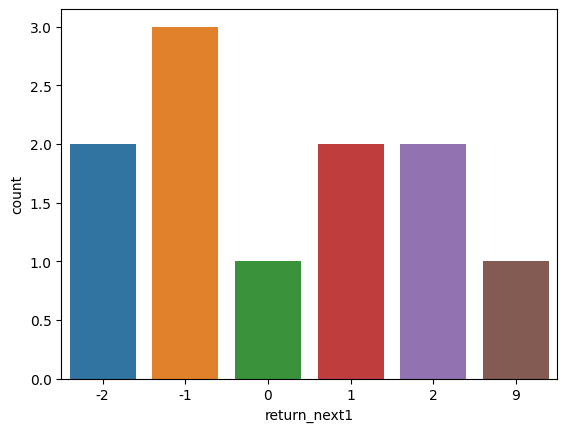

In [48]:
sns.countplot(data = df2, x="return_next1")